In [1]:
import pandas as pd
import os

DATA_DIR = 'data/'
PROCESSED_DATA_DIR = DATA_DIR + "processed/"

# Analyse du biais 

In [84]:
manual_transcription = pd.read_csv(PROCESSED_DATA_DIR+'manual_transcription.csv')
manual_transcription = manual_transcription[["annee","chef_vocation", "chef_vocation_transcripted", "pensionnaires_condition", "pensionnaires_condition_transcripted"]]

cols = ["chef_vocation","chef_vocation_transcripted","pensionnaires_condition","pensionnaires_condition_transcripted"]
manual_transcription[cols] = manual_transcription[cols].fillna("") \
                                .apply(lambda serie: serie.apply(lambda s: s.replace("·","").split('|')))
manual_transcription

,annee,chef_vocation,chef_vocation_transcripted,pensionnaires_condition,pensionnaires_condition_transcripted
0,1848,[froureux],[],[],[]
1,1848,[conservateur],[conservateur],[pensionnaire],[pensionnaire]
2,1848,[boulanger],[boulanger],[],[]
3,1848,[tailleuse],[tailleuse],"[ouvriere, apprentie]","[ouvriere, apprentie]"
4,1848,[relieur],[relieur],[],[]
...,...,...,...,...,...
518,1868,[md de lamis],[marchand de tamis],[],[]
519,1868,[rentiere],[rentiere],[arpenteur dque],[arpenteur]
520,1868,[charcutier],[charcutier],[],[domestique]
521,1868,[macon],[macon],[pensionnaire],[pensionnaire]


In [124]:
from ast import literal_eval

automatic_correction = pd.read_csv('data/processed/automatic_corrected_census.csv')
automatic_correction = automatic_correction[["annee","chef_vocation","pensionnaires_condition"]]
automatic_correction[["chef_vocation","pensionnaires_condition"]] = automatic_correction[["chef_vocation","pensionnaires_condition"]].applymap(literal_eval)
automatic_correction

,annee,chef_vocation,pensionnaires_condition
0,1861,[ve de framages],[]
1,1861,[journalier],[commis negociant]
2,1861,[caregent],[app cais negt]
3,1861,"[gaciant trapre, louis]","[pensionnaire, pensionnaire, domestique, ind]"
4,1861,[],"[id es, id es]"
...,...,...,...
378721,1858,[rentier],[]
378722,1858,[journalier],[]
378723,1858,[],[]
378724,1858,[fomme de lestre],[]


In [153]:
manual_transcription_1848 = manual_transcription[manual_transcription["annee"]==1848]
manual_transcription_1868 = manual_transcription[manual_transcription["annee"]==1868]

automatic_correction_1848 = automatic_correction[automatic_correction["annee"]==1848]
automatic_correction_1868 = automatic_correction[automatic_correction["annee"]==1868]

automatic_correction_1848 = automatic_correction_1848.iloc[:len(manual_transcription_1848)]
automatic_correction_1868 = automatic_correction_1868.iloc[:len(manual_transcription_1868)]

In [154]:
manual_transcription_1848

,annee,chef_vocation,chef_vocation_transcripted,pensionnaires_condition,pensionnaires_condition_transcripted
0,1848,[froureux],[],[],[]
1,1848,[conservateur],[conservateur],[pensionnaire],[pensionnaire]
2,1848,[boulanger],[boulanger],[],[]
3,1848,[tailleuse],[tailleuse],"[ouvriere, apprentie]","[ouvriere, apprentie]"
4,1848,[relieur],[relieur],[],[]
...,...,...,...,...,...
269,1848,[],[instituteur],[dque dque],"[pensionnaire, domestique]"
270,1848,"[ptrepreneur, rontr]",[entrepreneur],"[, pensre]",[domestique]
271,1848,[],[rentiere],"[id dque, , ]","[pensionnaire, pensionnaire, domestique]"
272,1848,[],[rentiere],[jnsti pensre],[domestique]


In [155]:
#automatic_correction_1848['chef_vocation'].reset_index().iloc[0].values[1]

In [156]:
#Idea: compute distribution of word length for 
#chef_vocation for original data, manually corrected, automatically corrected

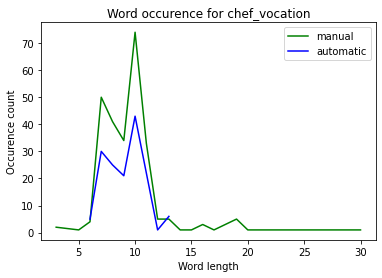

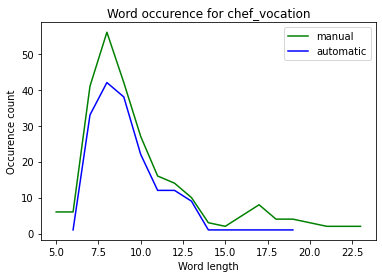

In [200]:
import matplotlib.pyplot as plt

kept_terms = set(pd.read_csv('data/processed/correct_terms.csv',index_col=0)['0'])

def word_length_distribution(col,only_keep_terms=False):
    col = col.fillna("").replace("NSP","").explode()
    if(only_keep_terms):
        col = col[col.isin(kept_terms)]
    col = col.apply(lambda s: len(s))
    
    value_counts = col.value_counts().sort_index()
    #Remove 0 size values
    value_counts = value_counts.drop(value_counts.index[0],axis='index')
    return value_counts

def plot_word_length(manual,automatic,title):
    word_length_manual = word_length_distribution(manual)
    word_length_automatic = word_length_distribution(automatic,only_keep_terms=True)
    
    plt.plot(word_length_manual,color='green', label='manual')
    plt.plot(word_length_automatic,color='blue', label='automatic')
    plt.xlabel('Word length')
    plt.ylabel('Occurence count')
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_word_length(manual_transcription_1848['chef_vocation_transcripted'],automatic_correction_1848['chef_vocation']
                 ,title="Word occurence for chef_vocation")

plot_word_length(manual_transcription_1868['chef_vocation_transcripted'],
                 automatic_correction_1868['chef_vocation']
                 ,title="Word occurence for chef_vocation")